# Wilcoxon Rank Sum Test
Here are some resources that may help with understanding this test:
* The Wilcoxon Rank Sum Test, University of Virginia: https://data.library.virginia.edu/the-wilcoxon-rank-sum-test/
* The Wilcoxon Rank-Sum Test, Univiersity of Auckland: https://www.stat.auckland.ac.nz/~wild/ChanceEnc/Ch10.wilcoxon.pdf
* Wilcoxon-Test (Wilcoxon Signed Rank Test): https://www.youtube.com/watch?v=NZsL2eDQiDQ
* How To... Perform a Wilcoxon Signed Rank Test (By Hand): https://www.youtube.com/watch?v=TqCg2tb4wJ0
* How To... Perform the Mann-Whitney U Test (By Hand): https://www.youtube.com/watch?v=BT1FKd1Qzjw
* Statistics 101: Nonparametric Methods, Mann-Whitney-Wilcoxon Rank Sum Test: https://www.youtube.com/watch?v=fEobVCV2TJE

### Intuition
The intuition behind this test is that we are trying to determine whether two distributions that have the same shape, but different spacial layout.

### Assumptions
1. The two samples are *are* dependent
1. The two populations have equal variance or spread

### Applications
* Single cell RNAseq
* When paired t-test is non-applicable
independent of one another (yet some sources say the two samples

# Example 1: Wilcoxon on paired data

## Loading in data and looking at it
We will be using Eugene O'Loughlin's example dataset from. How To... Perform a Wilcoxon Signed Rank Test (By Hand): https://www.youtube.com/watch?v=TqCg2tb4wJ0. The following data are measured aluminium content in different trees growing in a polluted area. We are asking the question 
> "**Is there a significant difference in the metal content between August and November?**"

In [21]:
library(rstatix)
library(ggpubr)
library(pals)
library(tidyr)
library(plyr)
library(dplyr)
library(openxlsx)
library(cowplot)
library(reshape2)
library(patchwork)
library(ggplot2)
library(Matrix)

In [2]:
df <- data.frame('Clone' = c("Columbia River", "Fritzi Pauley", "Hazen Dans", "Primo", "Raspalse", "Hoog Vorst", "Balsam Sare", "Gibecq", "Beau Poe", "Unal", "Trichobel", "Gaver", "Wolterson"),
                 'August' = c(18.3, 13.3, 16.5, 12.6, 9.5, 13.6, 8.1, 8.9, 10.0, 8.3, 7.9, 8.1, 13.4),
                 'November' = c(12.7, 11.1, 15.3, 12.7, 10.5, 15.6, 11.2, 14.2, 16.2, 15.5, 19.9, 20.4, 36.8))
df

Clone,August,November
<chr>,<dbl>,<dbl>
Columbia River,18.3,12.7
Fritzi Pauley,13.3,11.1
Hazen Dans,16.5,15.3
Primo,12.6,12.7
Raspalse,9.5,10.5
Hoog Vorst,13.6,15.6
Balsam Sare,8.1,11.2
Gibecq,8.9,14.2
Beau Poe,10.0,16.2


[1] "August summary:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7.90    8.30   10.00   11.42   13.40   18.30 

[1] 3.451607

[1] "November Summary:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.50   12.70   15.30   16.32   16.20   36.80 

[1] 6.887047

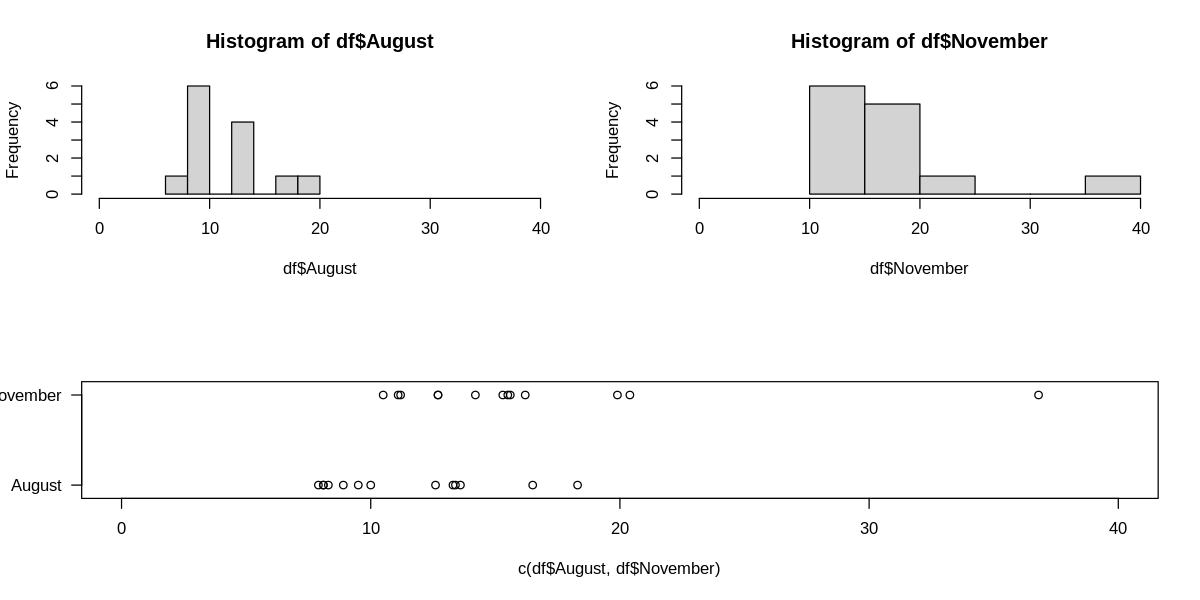

In [3]:
options(repr.plot.width=10, repr.plot.height=5)
#par(mfrow=c(1,3))
layout(matrix(c(1,2,3,3), 2, 2, byrow = TRUE))
hist(df$August, xlim = c(0,40))
hist(df$November, xlim = c(0,40))
plot(x = c(df$August, df$November), y = c(rep(1,13), rep(2,13)), 
     yaxt='n', ylim = c(0.9, 2.1), ylab='', xlim = c(0,40))
axis(2, at = c(1,2), las=2, labels = c('August', "November"))
print("August summary:")
summary(df$August)
sd(df$August)
print("November Summary:")
summary(df$November)
sd(df$November)

It looks like August may be normally distributed, but November doesn't.

## Setting up our hypotheses
M = median

Our null hypothesis is that the median of August != median of November.
\$H_0: M_{Aug}=M_{Nov}\$

Our alternative hypothesis is that the two medians are equal to each other.
\$H_a: M_{Aug}\neq M_{Nov}\$

We have `n = 13` samples and `alpha = 0.05`, these values come into play at the end of this when we are determining significance.

Now to calculate our test statistic, we need to calculate 4 additional columns
1. The signed difference between pairs of data
1. Sign of the differences (+ or -)
1. The absolute difference
1. Finally the rank

In [4]:
alpha = 0.05
n = 13

## Calculating differences and rank

In [5]:
df$diff <- df$November - df$August
df$sign <- sign(df$diff)
df$abs_diff <- abs(df$diff)
df$rank <- rank(df$abs_diff)
df

Clone,August,November,diff,sign,abs_diff,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Columbia River,18.3,12.7,-5.6,-1,5.6,8
Fritzi Pauley,13.3,11.1,-2.2,-1,2.2,5
Hazen Dans,16.5,15.3,-1.2,-1,1.2,3
Primo,12.6,12.7,0.1,1,0.1,1
Raspalse,9.5,10.5,1.0,1,1.0,2
Hoog Vorst,13.6,15.6,2.0,1,2.0,4
Balsam Sare,8.1,11.2,3.1,1,3.1,6
Gibecq,8.9,14.2,5.3,1,5.3,7
Beau Poe,10.0,16.2,6.2,1,6.2,9


When we look at this, the absolute difference is telling is if the tree has taken up more or less aluminum between the months of November and August. Looks like trees around the columbia river have actually *lost* alumninum content, while trees around the Wolterson river have gained a tremendous amount. Lastly, we rank the absolute differences. The ranking is important, because this is where the name of "rank sum test" comes into play, we will be summing all the positive ranks and all the negative ranks...why? I'm not sure. Note that R's rank will automatically handle ties for us and take the average of the rankings.

Plotting the values that are over and under the aluminum levels, we see that that later ranks (greater differences) are all positive! This indicates that the November values are larger, and quite a bit larger than the August values.

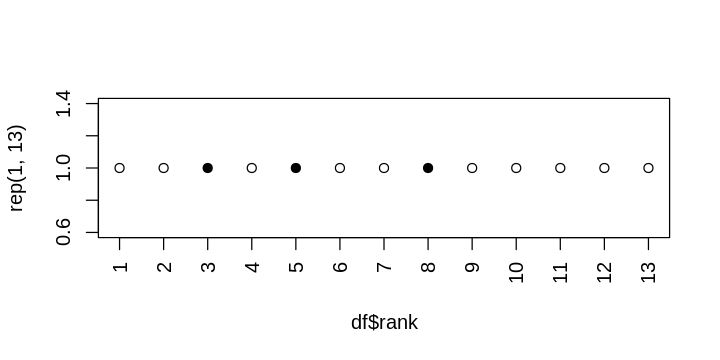

In [6]:
options(repr.plot.width=6, repr.plot.height=3)
plot(y = rep(1,13),x = df$rank, xaxt="n", pch = ifelse(df$sign<0, 19, 21))
axis(1, at = seq(1, 13, by = 1), las=2)

## Calculating the Rank Sums \$T_+\$ and \$T_-\$

In [7]:
Tminus = sum(df$rank[df$sign < 0])
Tplus = sum(df$rank[df$sign > 0])
paste0("Tminus: ",Tminus)
paste0("Tplus: ",Tplus)

[1] "Tminus: 16"

[1] "Tplus: 75"

W is the test statistic and it is just the smaller of these two values

In [8]:
W = min(Tminus, Tplus)
paste0("W: ", W)

[1] "W: 16"

## Determine a critical value to determine significance
We need to use a wilcoxon signed rank test table of critical values!
In this case, with 13 samples and our two tailed alpha value of 0.05, we are comparing our W to the critical value of `17`. By the way, in several tutorials, the teachers bring up \$\frac{n(n+1)}{2}\$ for some reason. Well if n = number of samples, this formula is just the sums of the series \$1 + 2 + 3 + ... + n\$! If we are doing this by hand, it may be prudent to do \$T_+ + T_-= \frac{n(n+1)}{2}\$ to make sure we got the ranks right. This link https://stats.stackexchange.com/questions/486601/where-do-wilcoxon-signed-rank-critical-values-come-from-ie-how-are-they-compute might explain where the $W_{crit}$ comes from, but I don't fully understand their explaination. For now let us just assume "fancy counting" and use the table.

> Because \$W < W_{crit}\$ we can, just like that, reject the null hypothesis $H_0$.

## Conclusion

Because our W statistic was less than the critical value at a significance level of 0.05, we can confidently reject the null hypothesis that the median difference is 0 in favor of the alternative hypothesis.

# Man Whitney U Test
The purpose of this notebook is to understand this statistical test a bit better. It is Farshad's favorite single cell differential expression test, and I want to not only intuitively understand it, but be able to recreate/implement it.

### Assumptions
1. The two samples are *are* INdependent
1. The two populations have equal variance or spread

### Applications
* Single cell RNAseq
* When paired t-test is non-applicable

# Example 2: Mann-Whitney U Test

## Loading in data and looking at it
We will be using Eugene O'Loughlin's example dataset from. How To... Perform the Mann-Whitney U Test (By Hand): https://www.youtube.com/watch?v=BT1FKd1Qzjw. The following data comparing the results of Treatment A and Treatment B (I think these are survey rankings). Immediately we know this is unpaired because we have two different groups being tested, and what is neat is we don't need to have equal numbers of observations in each group---even though in this case we do. We are asking the question 
> "**Is there a significant difference in the survey responses between Treatment A and Treatment B?**"

In [9]:
df = data.frame("TreatmentA" = c(3,4,2,6,2,5),
                "TreatmentB" = c(9,7,5,10,6,8))
n.a = length(df$TreatmentA)
n.b = length(df$TreatmentB)
df

TreatmentA,TreatmentB
<dbl>,<dbl>
3,9
4,7
2,5
6,10
2,6
5,8


[1] "TreatmentA summary:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.250   3.500   3.667   4.750   6.000 

[1] 1.632993

[1] "TreatmentB Summary:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00    6.25    7.50    7.50    8.75   10.00 

[1] 1.870829

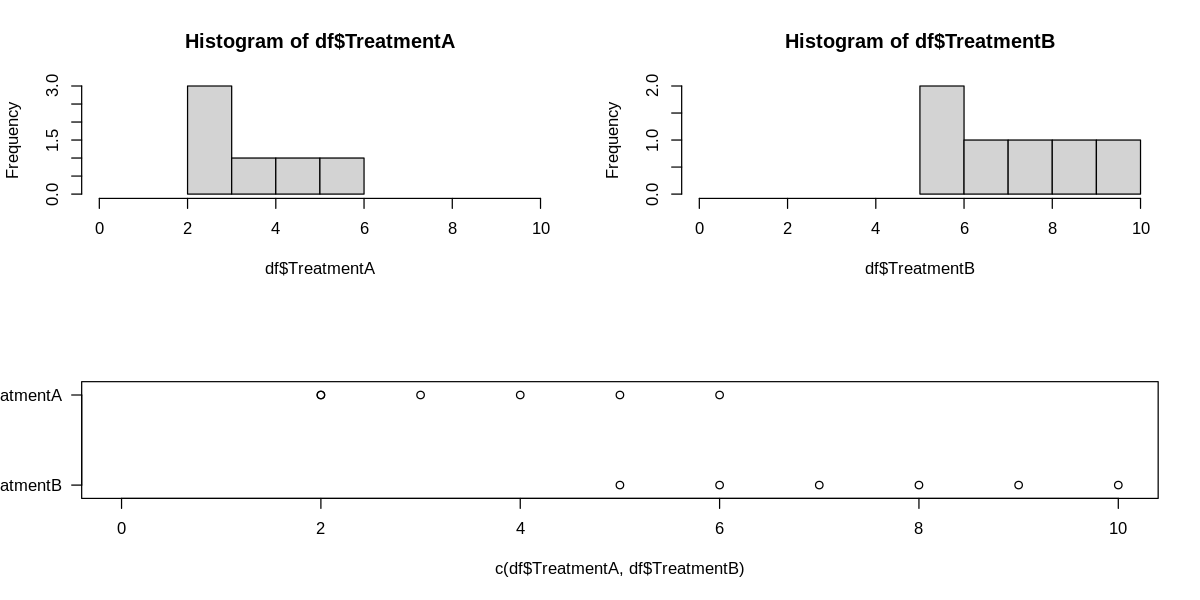

In [10]:
options(repr.plot.width=10, repr.plot.height=5)
#par(mfrow=c(1,3))
layout(matrix(c(1,2,3,3), 2, 2, byrow = TRUE))
hist(df$TreatmentA, xlim = c(0,10))
hist(df$TreatmentB, xlim = c(0,10))
plot(x = c(df$TreatmentA, df$TreatmentB), y = c(rep(2,6), rep(1,6)), 
     yaxt='n', ylim = c(0.9, 2.1), ylab='', xlim = c(0,10))
axis(2, at = c(2,1), las=2, labels = c('TreatmentA', "TreatmentB"))
print("TreatmentA summary:")
summary(df$TreatmentA)
sd(df$TreatmentA)
print("TreatmentB Summary:")
summary(df$TreatmentB)
sd(df$TreatmentB)

## Setting up our hypotheses
Our null hypothesis, \$H_0\$, is that there is *NO* difference between the ranks of our two treatments.

Our alternative hypothesis, \$H_A\$, is that there *IS* a difference between the ranks of our two treatments.

This already differs from the Wilcoxon test in just the hypotheses we are testing. Interesting.

We also need to define an alpha = 0.05 and we decide to use two-tailed, unpaired, independent Man-Whitney test.

## Combining the categories and ranking the scores

In [11]:
dfRanked = melt(df)
colnames(dfRanked) <- c('Treatment', 'Score')
dfRanked$Rank <- rank(dfRanked$Score)
dfRanked

No id variables; using all as measure variables



Treatment,Score,Rank
<fct>,<dbl>,<dbl>
TreatmentA,3,3.0
TreatmentA,4,4.0
TreatmentA,2,1.5
TreatmentA,6,7.5
TreatmentA,2,1.5
TreatmentA,5,5.5
TreatmentB,9,11.0
TreatmentB,7,9.0
TreatmentB,5,5.5


Here we will actually learn how to deal with ties! I explained it a bit above in the Wilcoxon test, but we get to see it in action here

## Sum the group ranks
This is the rank sum for each of my two groups. We can use these to do the calculation for the U-statistic which is gonna give us a p-value.

In [12]:
groupSum <- tapply(dfRanked$Rank, INDEX = dfRanked$Treatment, FUN = sum)
groupSum

TreatmentA TreatmentB 
        23         55

## Calculate the \$U_{stat}\$
The formula is $$U_{stat} = RANKSUM - \frac{n(n+1)}{2}$$ where n = number of samples in the group **NOT** summed (6 for either here). After calculation, we us the lower of the two values as our $U_{stat}$.

In [13]:
Ua = groupSum["TreatmentA"] - (n.b * (n.b + 1))/2
Ub = groupSum["TreatmentB"] - (n.a * (n.a + 1))/2
Ustat = min(Ua, Ub)
paste0("U stat of Treatment A: ", Ua)
paste0("U stat of Treatment B: ", Ub)
paste0("U stat: ", Ustat)

[1] "U stat of Treatment A: 2"

[1] "U stat of Treatment B: 34"

[1] "U stat: 2"

### Aside: why do we subtract the summed rank of the **other** treatment

Why are we subtracting max summed rank of one treatment from the apparent ranking of the other? I think it is because $\frac{n(n+1)}{2}$ is the smallest rank a set of $n$ numbers can be! So if one group completely occupies that space, then obviously the null hypothesis **has to be rejected** because there is just no way for one group to completely occupy the lower ranks unless the ranks are different.

In [14]:
# Well, if we had this
testgroup1 = c(1,2,3,4)
testgroup2 = c(5,6,7,8)
testRank = rank(c(testgroup1, testgroup2))
testRankSum1 = sum(c(1,2,3,4)); testRankSum1
testRankSum2 = sum(c(5,6,7,8)); testRankSum2
testRankSum1 - (4*5)/2
testRankSum2 - (4*5)/2
# Then I suppose if there is absolutely no overlap
# we get one value as being zero...but now what if the group sizes are unequal.
# Now, if we had this
testgroup1 = c(1,2,3,4)
testgroup2 = c(5,6,7,8,9)
testRank = rank(c(testgroup1, testgroup2))
testRankSum1 = sum(c(1,2,3,4)); testRankSum1
testRankSum2 = sum(c(5,6,7,8,9)); testRankSum2
testRankSum1 - (5*6)/2
testRankSum2 - (4*5)/2
# Well, now we are getting some shinanigans, 
# we can go into the negatives! 

[1] 10

[1] 26

[1] 0

[1] 16

[1] 10

[1] 35

[1] -5

[1] 25

## Determine a critical value to determine significance
Once again there are ables for this based on if we want to do one-tailed, two-tailed testing. The table depends on the n in group1 and n in group2, then based on the alpha we chose we get a critical value to compare against. In our case $U_{crit} = 5$.

## Conclusion
Because $U_{stat} \leq U_{crit}$, we can reject the null hypothesis $H_0$, and determine that there is statistically significant difference between TreatmentA and TreatmentB at an alpha of 0.05.

I also found this video which might be nice for its visuals
>Statistics 101: Nonparametric Methods, Mann-Whitney-Wilcoxon Rank Sum Test: https://www.youtube.com/watch?v=fEobVCV2TJE

3 situations for our distributions:

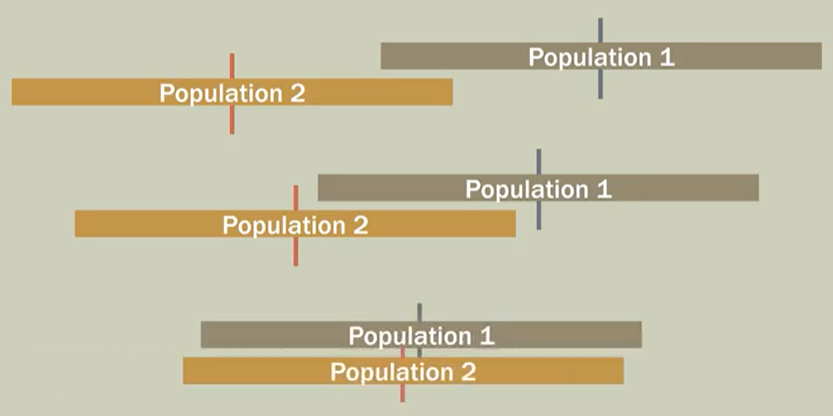

### Aside: How would I monte-carlo this?
Well, I would shuffle my data all together, choose with replacement a new group1 and a new group2, calculate the $groupSums_{monte}$ and $U_{statmonte}$, then at the end find the ratio of $\frac{U_{statmonte} \leq U_{stat}}{totalPerm}$.

In [19]:
df = data.frame("TreatmentA" = c(3,4,2,6,2,5),
                "TreatmentB" = c(9,7,5,10,6,8))
m.trials <- 100
list.of.Ustatmonte <- list()


for(i in 1:m.trials){
    rand.sample <- sample(1:length(c(df$TreatmentA, df$TreatmentB)), 6, replace = F)
    df2 <- data.frame("TreatmentA" = c(df$TreatmentA, df$TreatmentB)[rand.sample],
                      "TreatmentB" = c(df$TreatmentA, df$TreatmentB)[-rand.sample])

    suppressMessages(df2 <- melt(df2))
    colnames(df2) <- c("Treatment", "Score")
    df2$Rank <- rank(df2$Score)
    
    rankSum <- tapply(df2$Rank, df2$Treatment, FUN=sum)
    Ua = rankSum["TreatmentA"] - (6 * (6 + 1))/2
    Ub = rankSum["TreatmentB"] - (6 * (6 + 1))/2
    Ustatmonte <- min(Ua, Ub)
    list.of.Ustatmonte[[i]] <- Ustatmonte
}

list.of.Ustatmonte <- unlist(list.of.Ustatmonte)

[1] 0.01

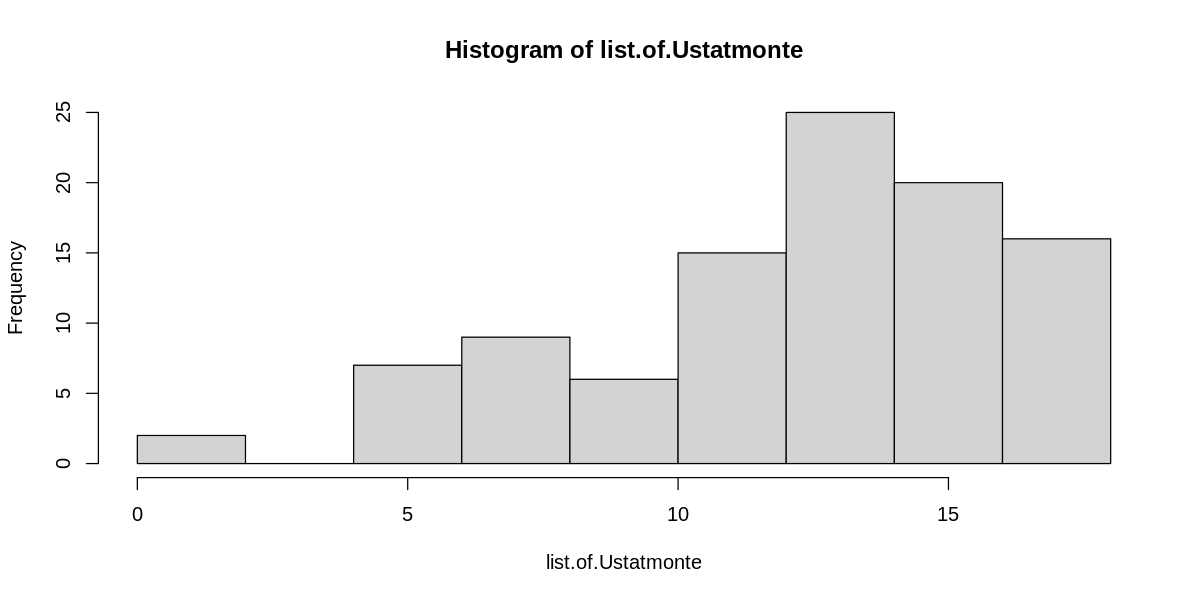

In [20]:
hist(list.of.Ustatmonte)
sum(list.of.Ustatmonte < Ustat) / m.trials

It works :))))))))) I guess there is a <1% chance of getting the survey results we got by random chance alone! We can safely reject the null hypothesis and conclude there is a difference in ranks between the two Treatment groups.